# Preprocessing steps and real-time statistical descriptions

## Importing Libraries

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import Imputer

In [2]:
# Create a spark session
spark = SparkSession.builder.appName("HAI-Preprocessing").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/29 17:52:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Data Loading

In [3]:
# Load data
train1 = spark.read.csv("/Users/emmatosato/Documents/UNI Locale/Erasmus/OST/ost-sm-change-detection/data_analysis/hai-train1.txt", header=True, inferSchema=True)
train2 = spark.read.csv("/Users/emmatosato/Documents/UNI Locale/Erasmus/OST/ost-sm-change-detection/data_analysis/hai-train2.txt", header=True, inferSchema=True)
test1 = spark.read.csv("/Users/emmatosato/Documents/UNI Locale/Erasmus/OST/ost-sm-change-detection/data_analysis/hai-test1.txt", header=True, inferSchema=True)
test2 = spark.read.csv("/Users/emmatosato/Documents/UNI Locale/Erasmus/OST/ost-sm-change-detection/data_analysis/hai-test2.txt", header=True, inferSchema=True)
label1 = spark.read.csv("/Users/emmatosato/Documents/UNI Locale/Erasmus/OST/ost-sm-change-detection/data_analysis/label-test1.txt", header=True, inferSchema=True)
label2 = spark.read.csv("/Users/emmatosato/Documents/UNI Locale/Erasmus/OST/ost-sm-change-detection/data_analysis/label-test2.txt", header=True, inferSchema=True)

## Data set insights

In [27]:
# First input
print(f"First input dimensions: ")
print(f"Train: ({train1.count()}, {len(train1.columns)})")
print(f"Test: ({test1.count()}, {len(test1.columns)})\n")

# Second input
print(f"Second input dimensions: ")
print(f"Train: ({train2.count()}, {len(train2.columns)})")
print(f"Test: ({test2.count()}, {len(test2.columns)})")

First input dimensions: 
Train: (103104, 87)
Test: (54000, 87)

Second input dimensions: 
Train: (291600, 87)
Test: (230400, 87)


In [28]:
train1.describe().show()

+-------+-----------------+------------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+--------------------+-------------------+-------------------+-----------+------------------+---------+---------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+---------+---------+--------------------+------------------+------------------+------------------+--------------------+------------------+-------------------+-----------------+--------+-------------------+-------------------+------------------+------------------+--------------------+------+-----------------+-------------------+------------------+--------------------+------------------+------------------+--------------

In [30]:
train2.describe().show()

+-------+------------------+------------------+----------------+------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-------------------+-----------+-------------------+---------+---------+---------+---------+--------+--------+------------------+------------------+------------------+---------+---------+-------+------------------+------------------+------------------+--------------------+-------------------+-------------------+------------------+--------+-------------------+-------------------+-------------------+-------------------+--------+------+------------------+-------------------+------------------+---------+------------------+-------------------+-------------------+-------------------+-------------------+--------+--------+--------+----

In [31]:
train1.printSchema()

root
 |-- timestamp: timestamp (nullable = true)
 |-- P1_FCV01D: double (nullable = true)
 |-- P1_FCV01Z: double (nullable = true)
 |-- P1_FCV02D: double (nullable = true)
 |-- P1_FCV02Z: double (nullable = true)
 |-- P1_FCV03D: double (nullable = true)
 |-- P1_FCV03Z: double (nullable = true)
 |-- P1_FT01: double (nullable = true)
 |-- P1_FT01Z: double (nullable = true)
 |-- P1_FT02: double (nullable = true)
 |-- P1_FT02Z: double (nullable = true)
 |-- P1_FT03: double (nullable = true)
 |-- P1_FT03Z: double (nullable = true)
 |-- P1_LCV01D: double (nullable = true)
 |-- P1_LCV01Z: double (nullable = true)
 |-- P1_LIT01: double (nullable = true)
 |-- P1_PCV01D: double (nullable = true)
 |-- P1_PCV01Z: double (nullable = true)
 |-- P1_PCV02D: double (nullable = true)
 |-- P1_PCV02Z: double (nullable = true)
 |-- P1_PIT01: double (nullable = true)
 |-- P1_PIT01_HH: integer (nullable = true)
 |-- P1_PIT02: double (nullable = true)
 |-- P1_PP01AD: integer (nullable = true)
 |-- P1_PP01AR: 

## Missing values handling

Printing the NaN values

In [59]:
def check_null_values(dataframe, name="DataFrame"):
    found_null_values = False
    
    print(f"{name} - Checking for Null Values:")
    
    # Iterate over columns and print only if there are null values
    for col_ in dataframe.columns:
        null_count = dataframe.select(sum(col(col_).isNull().cast("int")).alias(col_)).collect()[0][0]
        if null_count > 0:
            print(f"Column '{col_}': {null_count} null values")
            found_null_values = True
    
    # Print a message if no null values are found
    if not found_null_values:
        print(f"No null values found.\n")

In [57]:
'''
def check_null_values(dataframe, name="DataFrame"):
    dataframe = dataframe.toPandas()
    found_null_values = False
    
    print(f"{name} - Checking for Null Values:")
    
    # Iterate over columns and print only if there are null values
    for col_ in dataframe.columns:
        null_count = dataframe[col_].isnull().sum()
        if null_count > 0:
            print(f"Column '{col_}': {null_count} null values")
            found_null_values = True
    
    # Print a message if no null values are found
    if not found_null_values:
        print(f"No null values found.\n")
'''

In [60]:
# Check null values for the first input
print("FIRST data input")
check_null_values(train1, name="Train set")
check_null_values(test1, name="Test set")

# Check null values for the second input
print("\n\nSECOND data input")
check_null_values(train2, name="Train set")
check_null_values(test2, name="Test set")

FIRST data input
Train set - Checking for Null Values:


Column 'P4_ST_PS': 1 null values
Column 'P4_ST_PT01': 1 null values
Column 'P4_ST_TT01': 1 null values
Column 'x1001_05_SETPOINT_OUT': 1 null values
Column 'x1001_15_ASSIGN_OUT': 1 null values
Column 'x1002_07_SETPOINT_OUT': 1 null values
Column 'x1002_08_SETPOINT_OUT': 1 null values
Column 'x1003_10_SETPOINT_OUT': 1 null values
Column 'x1003_18_SETPOINT_OUT': 1 null values
Column 'x1003_24_SUM_OUT': 1 null values
Test set - Checking for Null Values:
No null values found.



SECOND data input
Train set - Checking for Null Values:


No null values found.

Test set - Checking for Null Values:


No null values found.



In [65]:
# Identify numeric columns (excluding timestamp columns)
column_subset = [col_ for col_ in train1.columns if train1.select(col_).dtypes[0][1] != "string" and col_ != "timestamp"]

# Impute NaN values with the median for numeric columns
imputer = Imputer(
    inputCols=column_subset,
    outputCols=[col_ for col_ in column_subset],
    strategy="median"
)

# Fit and transform the DataFrame
train1_imputed = imputer.fit(train1).transform(train1)

+-------------------+---------+---------+---------+---------+---------+---------+--------+---------+----------+----------+---------+---------+---------+---------+---------+---------+---------+---------+---------+--------+-----------+--------+---------+---------+---------+---------+--------+--------+--------+--------+---------+---------+---------+-------+--------+--------+--------+--------+------------+---------+---------+--------+-------+------------+-----------+-----------+--------+------+------+---------+--------+---------+----------+----------+----------+----------+--------+--------+--------+--------+--------+--------+---------+---------+-------+--------+-------+--------+--------+--------+--------+---------+--------+---------+---------+---------+--------+----------+----------+---------------------+-------------------+---------------------+---------------------+---------------------+---------------------+----------------+
|          timestamp|P1_FCV01D|P1_FCV01Z|P1_FCV02D|P1_FCV02Z|P

## Duplicated values handling

In [50]:
def check_duplicates(dataframe, name="DataFrame"):
    found_duplicates = False
    
    print(f"{name} - Checking for Duplicates:")
    
    # Get the count of each row
    row_count = dataframe.count()
    
    # Get the count of distinct rows
    distinct_row_count = dataframe.distinct().count()
    
    if (row_count - distinct_row_count) > 0:
        print(f"{row_count - distinct_row_count} duplicate rows found.")
        found_duplicates = True
    else:
        print(f"No duplicate rows found.\n")

In [ ]:
# Check duplicates for the first input
print("FIRST data input")
check_duplicates(train1, name="Train set")
check_duplicates(test1, name="Test set")

# Check duplicates for the second input
print("\n\nSECOND data input")
check_duplicates(train2, name="Train set")
check_duplicates(test2, name="Test set")


## Data exploration

### Plotting of random variables

In [61]:
train1_pd = train1.toPandas()
test1_pd = test1.toPandas()
label1_pd = label1.toPandas()

In [66]:
def plot_time_series(df, col):
    plt.figure(figsize=(20, 5))
    plt.plot(df[col])
    plt.title(col)
    plt.show()

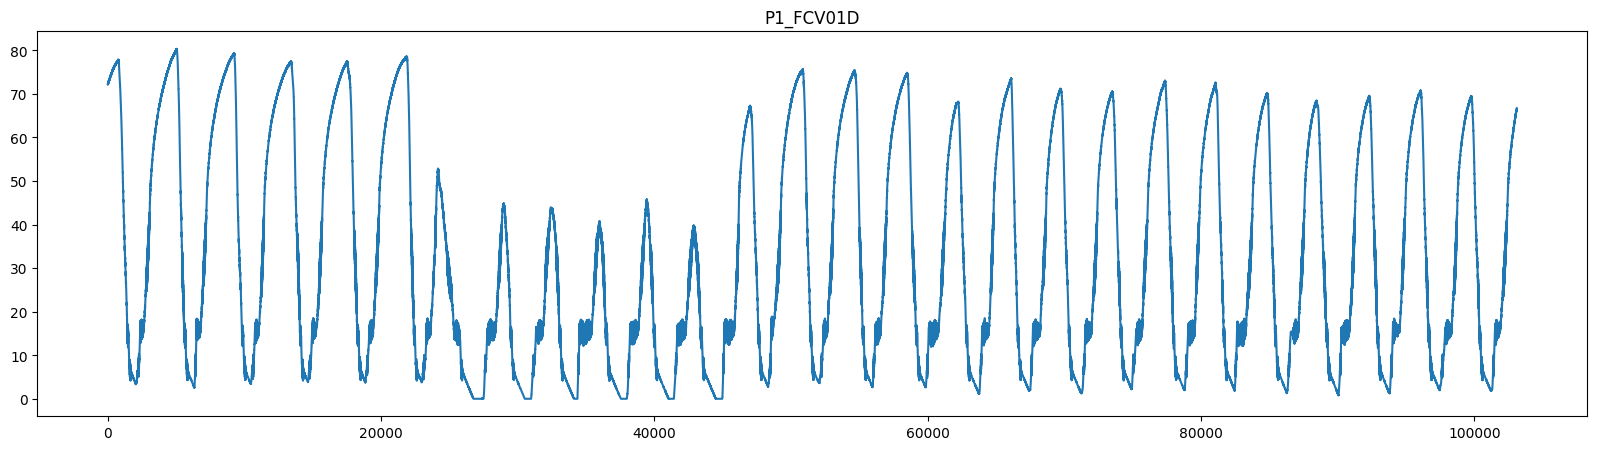

In [68]:
plot_time_series(train1_pd, "P1_FCV01D")

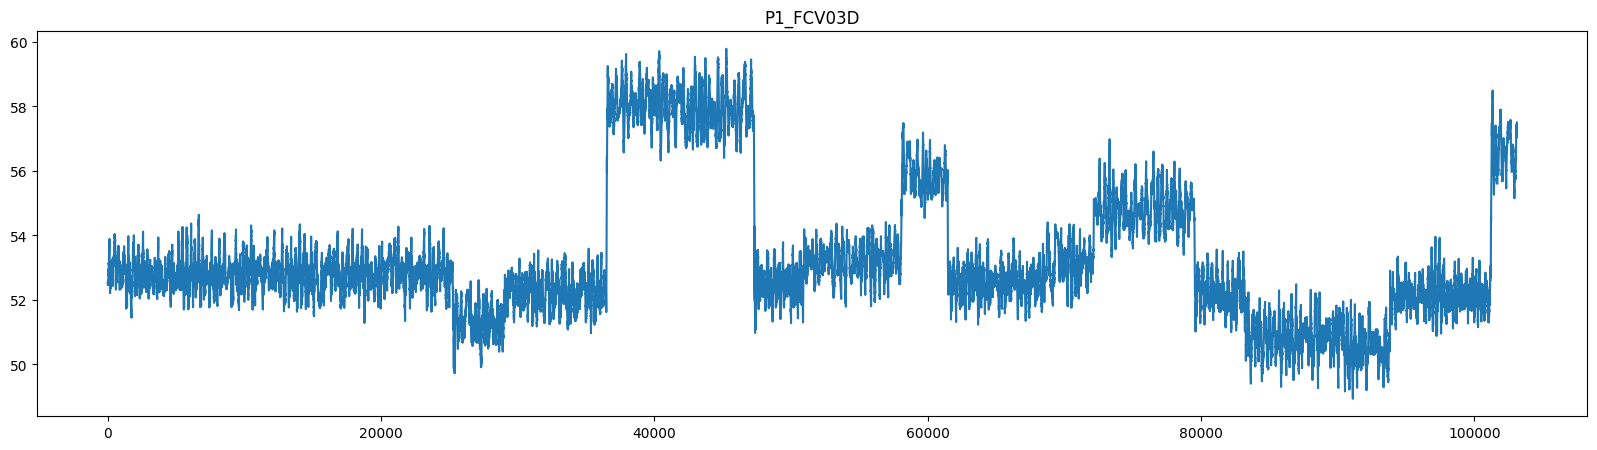

In [69]:
plot_time_series(train1_pd, "P1_FCV03D")

In [ ]:
plot_time_series(train1_pd, "")

In [ ]:
plot_time_series(train1_pd,"")

In [ ]:
plot_time_series(train1_pd, "")

### Distributions

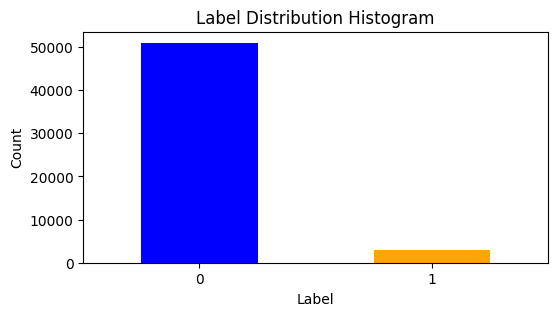

In [92]:
# Plot a histogram of the 'label' column
plt.figure(figsize=(6, 3))
label1_pd['label'].value_counts().sort_index().plot(kind='bar', color=['blue', 'orange'])
plt.title('Label Distribution Histogram')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [109]:
label1_pd[(label1_pd['label'] == 1) & (label1_pd['label'].shift() == 0)]

,timestamp,label
1503,2022-08-12 16:25:04,1
5700,2022-08-12 17:35:01,1
9136,2022-08-12 18:32:17,1
12063,2022-08-12 19:21:04,1
16980,2022-08-12 20:43:01,1
20160,2022-08-12 21:36:01,1
24420,2022-08-12 22:47:01,1
27314,2022-08-12 23:35:15,1
30303,2022-08-13 00:25:04,1
34448,2022-08-13 01:34:09,1


In [135]:
label1_pd[(label1_pd['label'] == 0) & (label1_pd['label'].shift() == 1)]

,timestamp,label
1741,2022-08-12 16:29:02,0
5899,2022-08-12 17:38:20,0
9293,2022-08-12 18:34:54,0
12228,2022-08-12 19:23:49,0
17142,2022-08-12 20:45:43,0
20358,2022-08-12 21:39:19,0
25025,2022-08-12 22:57:06,0
27411,2022-08-12 23:36:52,0
30434,2022-08-13 00:27:15,0
34504,2022-08-13 01:35:05,0


In [130]:
train1[train1['Timestamp'] =='2022-08-13 00:25:04']

,Timestamp,DM-PP01-R,DM-FT01Z,DM-FT02Z,DM-FT03Z,1001.2-OUT,1001.7-OUT1,1001.7-OUT2,1001.8-OUT,1002.2-OUT,...,DM-PCV01-D,DM-PCV01-Z,DM-PCV02-D,DM-PCV02-Z,DM-PIT01,DM-PIT02,DM-PWIT-03,DM-TIT01,DM-TIT02,DM-TWIT-03
1504,2022-08-12 16:25:04,0,277.271271,29.991373,976.592957,0,0,0,0,0,...,22.450037,22.477722,12.0,11.682127,0.857696,0.370941,0.000715,32.186886,38.442986,28.390686


In [138]:
changes_df = train1.iloc[1450: 1850]

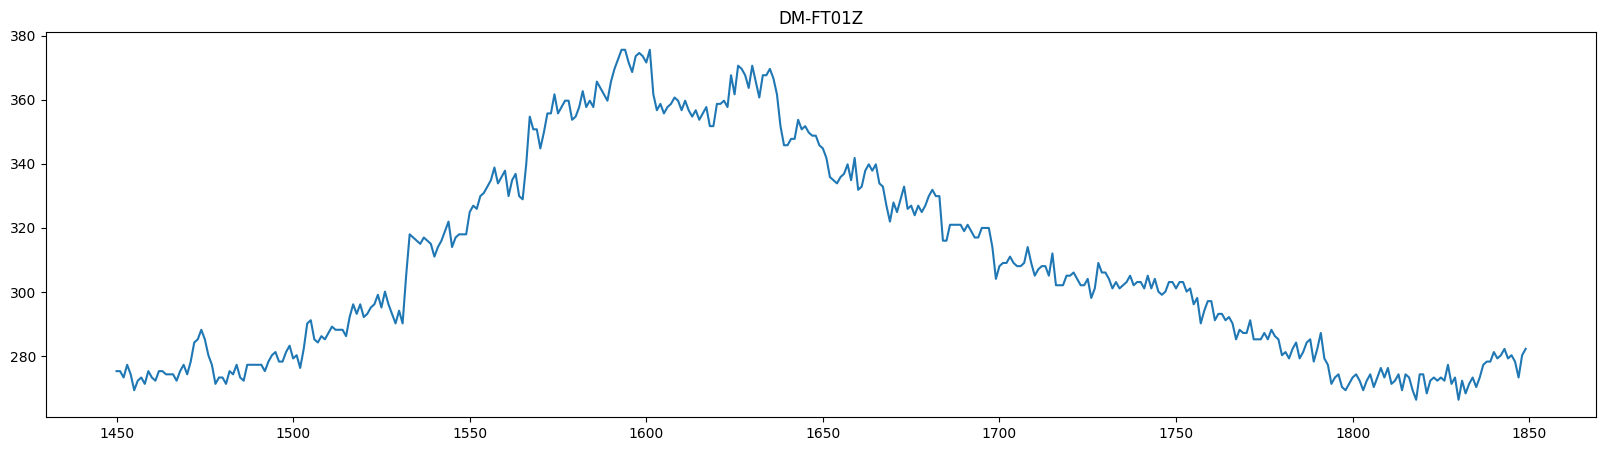

In [158]:
plot_time_series(changes_df, "DM-FT01Z")

/var/folders/07/b_mqfzkn0fzbvjz9y6nbfyf40000gn/T/ipykernel_35695/4232700415.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_hourly = sampling.groupby(sampling['Timestamp'].dt.hour).mean().reset_index()


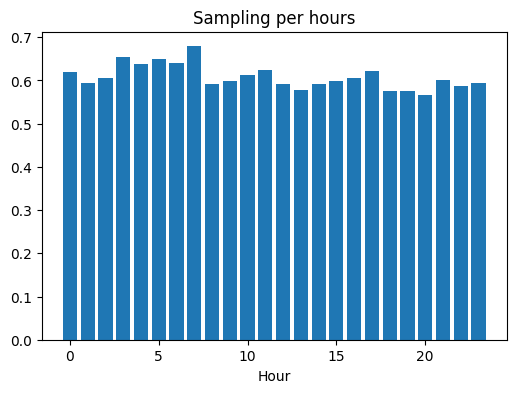

In [161]:
# Convert 'timestamp' to datetime format (if not already)
sampling = train1.copy()
sampling['Timestamp'] = pd.to_datetime(sampling['Timestamp'])

# Resample for the specific day with hourly frequency
df_hourly = sampling.groupby(sampling['Timestamp'].dt.hour).mean().reset_index()

# Plot the result
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(df_hourly.index, df_hourly['DM-PIT02'], width=0.8, align='center')
plt.title('Sampling per hours')
plt.xlabel('Hour')
plt.show()